In [1]:
import pandas as pd
import numpy as np
import data
import metrics
import models
import test
import matplotlib.pyplot as plt

from arch import arch_model
from scipy.stats import norm, uniform

import torch.nn as nn
import pyro
import torch
from pyro.nn.module import to_pyro_module_
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import MCMC, HMC, Predictive, NUTS

In [18]:
## ## stocks portfolio
## portfolio, weights = ['AMD', 'AMZN', 'GOOGL', 'NVDA', 'TSLA'], [0.1, 0.3, 0.1, 0.2, 0.3]
## returns = data.stocks_returns(portfolio, weights, from_date='09/02/2020', to_date='09/02/2022')
## 
## ## commodities
## portfolio, weights = ['Brent Oil', 'Crude Oil WTI', 'Natural Gas', 'Silver', 'Gold', 'Copper'], [0.05, 0.3, 0.1, 0.2, 0.3, 0.05]
## returns = data.commodities_returns(portfolio, weights, from_date='09/02/2020', to_date='09/02/2022')

## cryptocurrency portfolio
portfolio, weights = ['USDC', 'USDT', 'BUSD', 'ETH', 'XRP', 'DOGE', 'ADA'], [0.2, 0.2, 0.1, 0.3, 0.1, 0.05, 0.05]
returns = data.cryptocurrencies_returns(portfolio, weights, from_date='09/02/2020', to_date='09/02/2022')

logreturns = np.log(returns + 1)
_10day_logreturns = logreturns.rolling(10).sum().dropna()

Downloading...
From: https://drive.google.com/uc?id=1mPP5Vb57Jc2mYPeLYZPgAJM8ogjiguSO
To: D:\Documents\CMF\Importance Sampling\cryptocurrencies.csv

100%|███████████████████████████████████████████████████████████████████████████████| 174k/174k [00:00<00:00, 2.28MB/s]


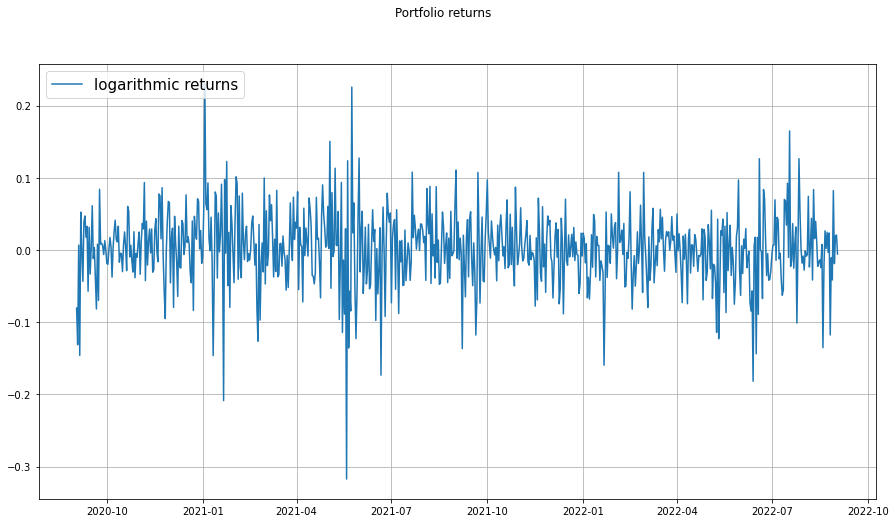

In [19]:
fig, ax1 = plt.subplots(1)
fig.set_size_inches(15,8)
fig.suptitle('Portfolio returns')

ax1.plot(logreturns.index, logreturns.values, '-', label = 'logarithmic returns')
ax1.grid()
ax1.legend(fontsize = 15, loc = 2)
plt.show()

In [20]:
loader =  data.Dataloader(series=logreturns, window_size=125, step_size=1, horizon=1, first_pred=125+1)
X = []
y = []
for _1, _2 in loader:
    feat, target = _1, _2
    X.append(feat)
    y.append(target)

window_size = 10
X = []
y = []
for i in range(len(feat) - window_size - 1):
    X.append(feat.iloc[i: i+window_size].values.tolist())
    y.append(feat.iloc[i+window_size+1])

X, y = np.array(X), np.array(y).reshape(len(y), 1)

# MCMC Implementation

## NUTS with Bayesian Neural Network

In [21]:
class Model(PyroModule):
    def __init__(self, input_size = 10, h1=20, h2=1):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_size, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 2).expand([h1, input_size]))#.to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(1, 1).expand([h1]))#.to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 2).expand([h2, h1]))#.to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(1, 1).expand([1]))#.to_event(1))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, y=None):
        x = self.tanh(self.fc1(x))
        mu = self.fc2(x).squeeze()
        # sigma = pyro.sample("sigma", dist.Uniform(0., 0.02))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, 1), obs=y)

model = Model()

In [22]:
hmc_nn = NUTS(model) # not HMC, otherwise you need to tune parameters of HMC
mcmc = MCMC(hmc_nn, num_samples = 400, warmup_steps = 100)
mcmc.run(torch.tensor(X).to(torch.float32), torch.tensor(y).to(torch.float32))

Sample: 100%|█████████████████████████████████████████| 500/500 [20:02,  2.40s/it, step size=1.52e-03, acc. prob=0.970]


## Backtesing

In [23]:
%%time
backtest = {'ts':[], 'actual_return':[], 'mean_simulated_return':[], 'VaR 95%':[], 'VaR 98.1%':[]}
n_paths = 1_000
samples = mcmc.get_samples()

for i in range(logreturns.shape[0]-19):
    X_train = np.tile(np.array(logreturns[i:i+10]), n_paths).reshape(n_paths,10)
    ts = logreturns.index[i+19]
    paths = np.zeros(n_paths)
    
    for day in range(10):
        predictive = Predictive(model, posterior_samples = samples)(torch.tensor(X_train).to(torch.float32), None) 
        X_train = np.hstack((X_train[:, 1:],np.array(predictive['obs'].mean(axis=0).reshape(n_paths,1))))
        paths = np.vstack((paths, np.array(predictive['obs'].mean(axis=0))))
        
    simulated_returns = np.sum(paths, axis=0)
    backtest['ts'].append(ts)
    backtest['actual_return'].append(_10day_logreturns[ts])
    backtest['mean_simulated_return'].append(np.mean(simulated_returns))
    backtest['VaR 95%'].append(np.quantile(simulated_returns, 1-0.95))
    backtest['VaR 98.1%'].append(np.quantile(simulated_returns, 1-0.981))

CPU times: total: 3h 1min 19s
Wall time: 30min 28s


In [24]:
backtest = pd.DataFrame(backtest)
backtest.tail()

,ts,actual_return,mean_simulated_return,VaR 95%,VaR 98.1%
707,2022-08-29,-0.037832,-0.027604,-0.305370,-0.349409
708,2022-08-30,-0.034256,-0.034551,-0.284902,-0.338865
709,2022-08-31,-0.041334,-0.035107,-0.294617,-0.347043
710,2022-09-01,-0.022622,-0.030888,-0.292113,-0.334766
711,2022-09-02,-0.052765,-0.020321,-0.269123,-0.347963


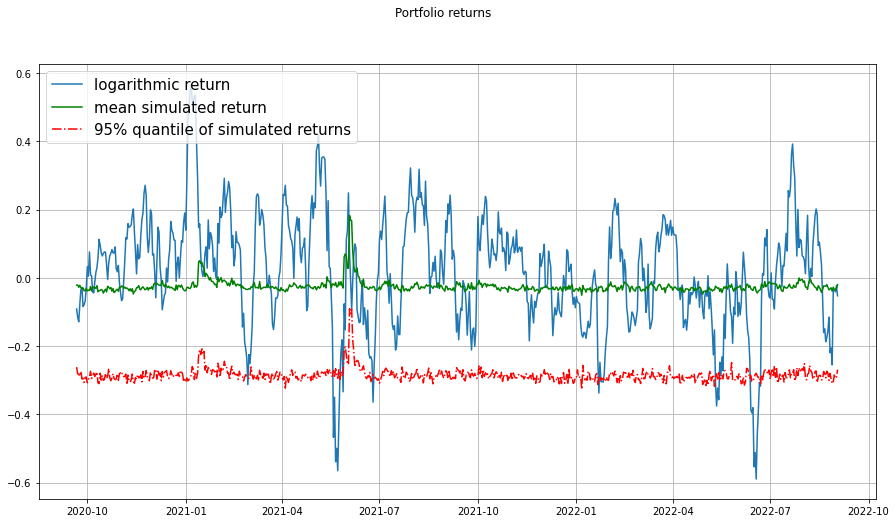

In [25]:
fig, ax1 = plt.subplots(1)
fig.set_size_inches(15,8)
fig.suptitle('Portfolio returns')

ax1.plot(backtest.ts, backtest.actual_return, '-', label = 'logarithmic return')
ax1.grid()
ax1.plot(backtest.ts, backtest.mean_simulated_return, 'g-', label = 'mean simulated return')
ax1.plot(backtest.ts, backtest['VaR 95%'], 'r-.', label = '95% quantile of simulated returns')

ax1.legend(fontsize = 15, loc = 2)
plt.show()

## Prediction

In [26]:
n_paths = 1_000
paths = np.zeros(n_paths)

samples = mcmc.get_samples()
X_train = np.array(torch.tensor(X).to(torch.float32)[-1])
X_train = np.tile(X_train, n_paths).reshape(n_paths,10)

for day in range(10):
    predictive = Predictive(model, posterior_samples = samples)(torch.tensor(X_train).to(torch.float32), None) 
    X_train = np.hstack((X_train[:, 1:],np.array(predictive['obs'].mean(axis=0).reshape(n_paths,1))))
    paths = np.vstack((paths, np.array(predictive['obs'].mean(axis=0))))
    
simulated_returns = np.sum(paths, axis=0)
np.quantile(simulated_returns, 1-0.95)

## backtest, increase num samples, change portfolio or to index

-0.27052677437895906

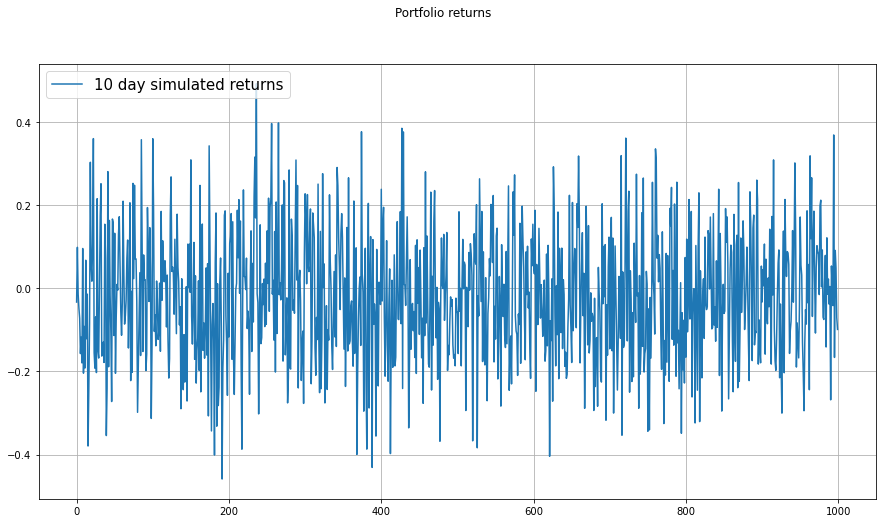

In [32]:
fig, ax1 = plt.subplots(1)
fig.set_size_inches(15,8)
fig.suptitle('Portfolio returns')

ax1.plot(simulated_returns, '-', label = '10 day simulated returns')
ax1.grid()

ax1.legend(fontsize = 15, loc = 2)
plt.show()

## HMC with GARCH(1,1) model. 
### Daily returns  cannot be used here. Problem - 1 day ahead prediction of volatility can be made accurately. The other 9 days are unavailable. 
### Must restate the X and y vectors

In [5]:
window_size = 25
X = []
y = []

for i in range(_10day_logreturns.shape[0] - window_size*10):
    _10day_logreturns
    X_idx = [i+j*10 for j in range(window_size)] ## 1, 11, 21, 31, 41 for i=1 and window_size = 5
    y_idx = i + window_size*10 ## 51 for i=1 and window_size = 5
    X.append(_10day_logreturns.iloc[X_idx])
    y.append(_10day_logreturns.iloc[y_idx])

X, y = np.array(X), np.array(y).reshape(len(y), 1)

In [9]:
def model(X, y):
    ## ARMA(0,0) with intercept - GARCH(1,1) model
    ## Sample weight
    GARCH_const = pyro.sample("GARCH_const", dist.Uniform(0.01, 0.5))
    GARCH_coef1 = pyro.sample("GARCH_coef1", dist.Uniform(0.01, 1))
    GARCH_coef2 = pyro.sample("GARCH_coef2", dist.Uniform(0.01, 1))
    
    prediction = X.mean(axis = 1).reshape( X.mean(axis = 1).shape[0], 1 )
    add_to_vol = ((y - prediction)**2)
    
    sigma2_array = np.zeros(X.shape[0])
    sigma2 = GARCH_const/(1 - GARCH_coef1 - GARCH_coef2)
    sigma2_array[0] = sigma2
    
    for i in range(X.shape[0]-1):
        sigma2_array[i+1] = GARCH_const + GARCH_coef1 * add_to_vol[i] + GARCH_coef2 * sigma2_array[i]
    
    for i in range(X.shape[0]-1):
        with pyro.plate("plate"):
            pyro.sample(f'obs_{i+1}', dist.Normal(prediction[i][0], np.sqrt(sigma2_array[i])), obs=y[i+1]) 

hmc_garch = NUTS(model)

mcmc_garch = MCMC(hmc_garch, num_samples = 100, warmup_steps = 40)
mcmc_garch.run(torch.tensor(X).to(torch.float32), torch.tensor(y).to(torch.float32))
samples = mcmc_garch.get_samples()

Warmup:   0%|                                                                                    | 0/140 [00:00, ?it/s]C:\Users\galex\AppData\Local\Temp\ipykernel_6228\2286360690.py:20: RuntimeWarning: invalid value encountered in sqrt
  pyro.sample(f'obs_{i+1}', dist.Normal(prediction[i][0], np.sqrt(sigma2_array[i])), obs=y[i+1])
Sample: 100%|███████████████████████████████████████| 140/140 [2:45:58, 71.13s/it, step size=4.57e-03, acc. prob=0.574]


In [10]:
n_paths = 1_000
backtest = {'ts':[], 'actual_return':[], 'mean_simulated_return':[], 'VaR 95%':[], 'VaR 98.1%':[]}
paths = np.zeros(n_paths)
what_coefficients_to_take = []
for i in range(n_paths):
    what_coefficients_to_take.append(int(pyro.sample('RNG', dist.Uniform(0, 100-1)))) ## 100 - num_samples

## define the coefficients from the samples
GARCH_const = samples['GARCH_const'][what_coefficients_to_take]
GARCH_coef1 = samples['GARCH_coef1'][what_coefficients_to_take]
GARCH_coef2 = samples['GARCH_coef2'][what_coefficients_to_take]

sigma2_array = np.zeros(X.shape[0])
sigma2 = GARCH_const/(1 - GARCH_coef1 - GARCH_coef2)
sigma2_array = np.array(sigma2).reshape(n_paths, 1)

for i in range(X.shape[0]):
    X_train = X[i]
    y_train = y[i]
    ts = logreturns.index[i+19]
    
    ## compute sigmas
    prediction = np.mean(X_train)
    add_to_vol = ((y_train - prediction)**2)
    
    new_sigma2 = np.array(GARCH_const)
    new_sigma2 += add_to_vol * np.array(GARCH_coef1)
    new_sigma2 += (np.array(sigma2_array[:,i]) * np.array(GARCH_coef2))
    sigma2_array = np.hstack((sigma2_array, new_sigma2.reshape(n_paths,1)))
    
    ## forecast the 10-day returns
    simulated_returns = np.array([pyro.sample('prediction', dist.Normal(prediction, np.sqrt(sigma2))) for sigma2 in new_sigma2])
    paths = np.vstack((paths, simulated_returns))
    
    backtest['ts'].append(ts)
    backtest['actual_return'].append(_10day_logreturns[ts])
    backtest['mean_simulated_return'].append(np.mean(simulated_returns))
    backtest['VaR 95%'].append(np.quantile(simulated_returns, 1-0.95))
    backtest['VaR 98.1%'].append(np.quantile(simulated_returns, 1-0.981))
    
paths = paths[1:,:]

In [11]:
backtest = pd.DataFrame(backtest)
backtest.tail()

,ts,actual_return,mean_simulated_return,VaR 95%,VaR 98.1%
467,2022-01-01,-0.054790,-0.031273,-0.224515,-0.266837
468,2022-01-02,-0.070165,-0.039626,-0.224724,-0.268610
469,2022-01-03,-0.073402,-0.033848,-0.214196,-0.261651
470,2022-01-04,-0.075884,-0.041637,-0.226930,-0.274437
471,2022-01-05,-0.135875,-0.037393,-0.214249,-0.278852


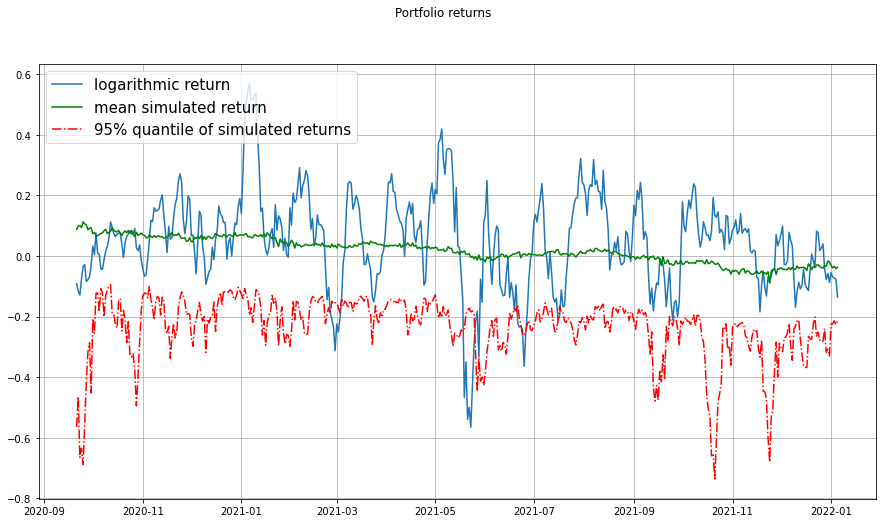

In [14]:
fig, ax1 = plt.subplots(1)
fig.set_size_inches(15,8)
fig.suptitle('Portfolio returns')

ax1.plot(backtest.ts, backtest.actual_return, '-', label = 'logarithmic return')
ax1.grid()
ax1.plot(backtest.ts, backtest.mean_simulated_return, 'g-', label = 'mean simulated return')
ax1.plot(backtest.ts, backtest['VaR 95%'], 'r-.', label = '95% quantile of simulated returns')

ax1.legend(fontsize = 15, loc = 2)
plt.show()

In [12]:
X_predict = []
for i in range(10):
    X_idx = [i-10*j-10 for j in range(0,window_size)]
    X_idx = X_idx[::-1]
    X_predict.append(_10day_logreturns.iloc[X_idx])
X_predict = np.array(X_predict)

In [13]:
%%time
n_paths = 1_000
predictions = {'ts':[], 'mean_simulated_return':[], 'VaR 95%':[], 'VaR 98.1%':[]}
predictions_paths = np.zeros(n_paths)
what_coefficients_to_take = []
for i in range(n_paths):
    what_coefficients_to_take.append(int(pyro.sample('RNG', dist.Uniform(0, 100-1)))) ## 100 - num_samples

## define the coefficients from the samples
GARCH_const = samples['GARCH_const'][what_coefficients_to_take]
GARCH_coef1 = samples['GARCH_coef1'][what_coefficients_to_take]
GARCH_coef2 = samples['GARCH_coef2'][what_coefficients_to_take]

for i in range(X_predict.shape[0]):
    X_train = X_predict[i]
    ts = _10day_logreturns.index[-1] + pd.Timedelta(f'{i} day')
    
    ## compute sigmas
    prediction = np.mean(X_train)
    ## add_to_vol parameter remains the same as the last we got
    ## add_to_vol = ((y_train - prediction)**2)  
    
    new_sigma2 = np.array(GARCH_const)
    new_sigma2 += add_to_vol * np.array(GARCH_coef1)
    new_sigma2 += (np.array(sigma2_array[:,-1]) * np.array(GARCH_coef2))
    
    ## forecast the 10-day returns
    simulated_returns = np.array([pyro.sample('prediction', dist.Normal(prediction, np.sqrt(sigma2))) for sigma2 in new_sigma2])
    predictions_paths = np.vstack((predictions_paths, simulated_returns))
    
    predictions['ts'].append(ts)
    predictions['mean_simulated_return'].append(np.mean(simulated_returns))
    predictions['VaR 95%'].append(np.quantile(simulated_returns, 1-0.95))
    predictions['VaR 98.1%'].append(np.quantile(simulated_returns, 1-0.981))
    
predictions_paths = predictions_paths[1:,:]
        
predictions = pd.DataFrame(predictions)
predictions.tail()

CPU times: total: 703 ms
Wall time: 703 ms


,ts,mean_simulated_return,VaR 95%,VaR 98.1%
5,2022-09-07,-0.036240,-0.218952,-0.257533
6,2022-09-08,-0.041766,-0.208534,-0.274914
7,2022-09-09,-0.036140,-0.219547,-0.264317
8,2022-09-10,-0.035925,-0.213372,-0.258778
9,2022-09-11,-0.038985,-0.235039,-0.283426


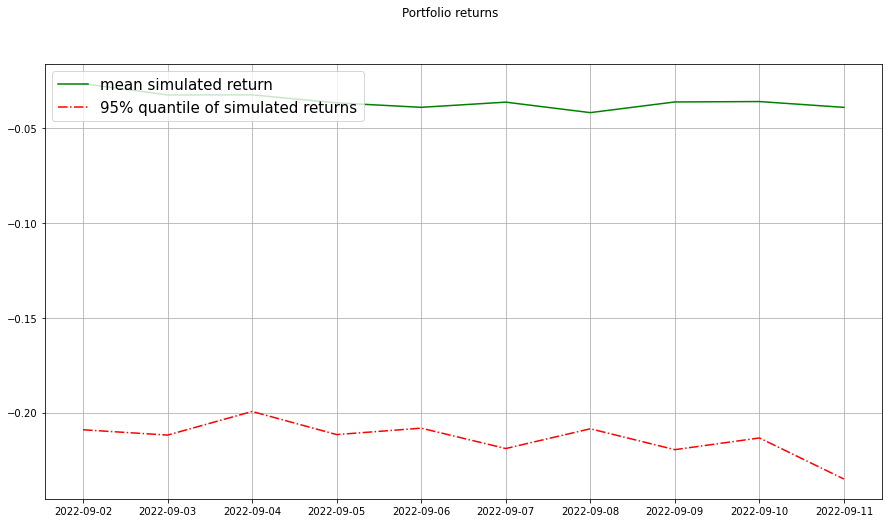

In [15]:
fig, ax1 = plt.subplots(1)
fig.set_size_inches(15,8)
fig.suptitle('Portfolio returns')

ax1.grid()
ax1.plot(predictions.ts, predictions.mean_simulated_return, 'g-', label = 'mean simulated return')
ax1.plot(predictions.ts, predictions['VaR 95%'], 'r-.', label = '95% quantile of simulated returns')

ax1.legend(fontsize = 15, loc = 2)
plt.show()